In [1]:
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

Define the model

In [2]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

Initialize hidden states using tensors

In [3]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

We can update the new hidden state and outputs from a hidden state and an input

In [4]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

Define a RNNModel class

In [8]:
class RNNModel(nn.Module):
    """Recurrent Neural Network Model"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)
    
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # RNN in torch does not include the final linear layer
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state
    
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens), 
                                device=device)
        else:
            return (torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens),
                                device=device),
                    torch.zeros((self.num_directions * self.rnn_num_layers,
                                batch_size, self.num_hiddens),
                                device=device)
                   )

Predict using a model with random weights

In [29]:
def _predict(prefix, num_preds, net, vocab, device):
    """
    Generate new tokens after 'prefix'
    """
    state = net.begin_state(batch_size=1, device=device) 
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], 
                                     device=device).reshape(1, 1)
    for y in prefix[1:]:
        _, state = net(get_input(), state) 
        # do not care about output because we know the answer here, which is y.
        # We only need the state from the prefix
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y, state = net(get_input(), state) # y: 1 * vocab_size
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [15]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
predict('time traveller', 10, net, vocab, device)

'time travelleriiorjg ben'

In [21]:
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm # Make change in-place
            
def train_epoch(net, train_iter, loss, updater, device, 
                    use_random_iter):
    # use_random_iter: True if the ith sample in the next batch is irrelevant to the last batch
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device= device)
        else: 
            # if not the first batch or using sequence iterator, no initialization, only detach
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean() # loss for a multi-class classification problem
        # standard procedure for multiclass classification
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel()) # cross entropy = loss * batch_size
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop() # exp --> perplexity

        

In [30]:
def train(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """ Train the model """
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: _predict(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(net, train_iter, loss, updater, device, 
                                    use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'Perplexity {ppl:.1f}, {speed:.1f} iter/s {str(device)}')
    print(predict('time_traveller'))
    print(predict('traveller'))

Perplexity 1.3, 364637.2 iter/s cuda:0
time<unk>traveller ffresisne ffitthes thin gon this boult so lligpes
travellerionstidet thatluraredyee sacd are alout the room a


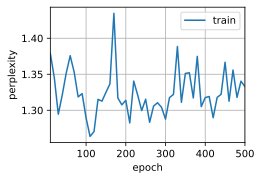

In [31]:
num_epochs, lr = 500, 1
train(net, train_iter, vocab, lr, num_epochs, device)